# 1. Config MLflow

In [38]:
# 🚀 Configuración MLflow (File Store local ./mlruns)
import os, json, time, sys
from pathlib import Path
import mlflow
import mlflow.sklearn

TRACKING_DIR = Path("mlruns").resolve()
TRACKING_DIR.mkdir(parents=True, exist_ok=True)

# Usamos URI tipo file://... de manera portable (Windows/macOS/Linux)
TRACKING_URI_FILE = TRACKING_DIR.as_uri()
mlflow.set_tracking_uri(TRACKING_URI_FILE)

EXPERIMENT_NAME = "MLflow Diabetes Linear Regression"
mlflow.set_experiment(EXPERIMENT_NAME)

print("MLflow version:", mlflow.__version__)
print("Tracking URI (file):", mlflow.get_tracking_uri())
print("Experiment:", EXPERIMENT_NAME)

MLflow version: 3.4.0
Tracking URI (file): file:///home/uwu/MLOps/T01/mlruns
Experiment: MLflow Diabetes Linear Regression


In [39]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from mlflow.models.signature import infer_signature

# 2. Cargar datos, split e Hiperparámetro

In [40]:
# Cargar dataset de diabetes
X, y = datasets.load_diabetes(return_X_y=True)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
# Hiperparámetros (para registrar)
params = {
    "fit_intercept": True
}

# 3. Entrenamiento (modelo) y logging (métricas)

In [42]:
import sys
print(sys.executable)


/home/uwu/MLOps/T01/.venv/bin/python


In [43]:
import mlflow
print("MLflow cargado ✅", mlflow.__version__)


MLflow cargado ✅ 3.4.0


In [44]:
with mlflow.start_run() as run:
    run_id = run.info.run_id
    print("Run ID:", run_id)
    
    # Entrenar modelo
    model = LinearRegression(**params)
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = model.predict(X_test)
    
    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE: {mse:.4f}, R²: {r2:.4f}")
    
    # Log params y métricas
    mlflow.log_params(params)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)

Run ID: d68c774237424080801a8e5046b834d6
MSE: 2900.1936, R²: 0.4526


# 4. Artefactos extra

a) Gráfico real vs predicho

In [45]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, alpha=0.7)
ax.plot([y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()], "r--", lw=2)
ax.set_xlabel("Valor real")
ax.set_ylabel("Predicción")
ax.set_title("Diabetes - Real vs Predicho")
plt.tight_layout()
mlflow.log_figure(fig, "real_vs_predicho.png")
plt.close(fig)


b) Guardar métricas como JSON

In [46]:
report = {"mse": mse, "r2": r2}
with open("metrics_report.json", "w") as f:
    json.dump(report, f, indent=2)
mlflow.log_artifact("metrics_report.json")

# 5. Registrar Modelo

In [47]:
signature = infer_signature(X_test, model.predict(X_test))
input_example = X_test[1]

registered_name = "Diabetes-LinearReg-MLflow"
try:
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        registered_model_name=registered_name,
        signature=signature,
        input_example=input_example
    )
    print(f"Modelo registrado como: {registered_name}")
except Exception:
    print("Model Registry no disponible. Se guardó el modelo como artefacto.")
    
# Guardamos el run_id para uso posterior
with open("last_run_id_file_store.txt", "w") as f:
    f.write(run_id)

print("✅ Entrenamiento y logging finalizados en file store.")
    

2025/10/03 17:13:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/03 17:13:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/03 17:13:58 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    0.09256398319871433,
    -0.04.... Alternatively, you can avoid passing input example and pass model signature instead when logging the model. To ensure the input example is valid prior to serving, please try calling `mlflow.models.validate_serving_input` on the model uri and serving input example. A serving input example can be generated from model input example using `mlflow.models.convert_input_example_to_serving_input` function.
Got error: Failed to enforce schema of data '[ 0.09256398 -0.04464164  0.03690653  0.02187239 -0.02496016 -0.01665815
  0.00077881 -0.03949338 -0.02251653 -0.02178823]' 

Modelo registrado como: Diabetes-LinearReg-MLflow
✅ Entrenamiento y logging finalizados en file store.


Registered model 'Diabetes-LinearReg-MLflow' already exists. Creating a new version of this model...
Created version '2' of model 'Diabetes-LinearReg-MLflow'.


# 6. Prediccioneas con nuevos datos

In [48]:
new_data = np.array([
    [0.038075906, 0.05068012, 0.06169621, 0.02187235, -0.0442235,
     -0.03482076, -0.04340085, -0.00259226, 0.01990749, -0.01764613],

    [-0.001882016, 0.04445121, -0.05147406, -0.02632795, -0.00844872,
     -0.01916334, 0.07441156, -0.03949338, -0.06833155, -0.09220405]
])

In [49]:
predictions = model.predict(new_data)
print("\n Predicciones para nuevos datos:")

for i, pred in enumerate(predictions):
    print(f"Fila {i+1}: {pred:.4f}")


 Predicciones para nuevos datos:
Fila 1: 210.7421
Fila 2: 47.8793


In [50]:
# 🖥️ Abrir la UI de MLflow (File Store) en http://127.0.0.1:5000
import subprocess, time, sys
from pathlib import Path

HOST = "127.0.0.1"
UI_PORT = 5000

# Nota: '--backend-store-uri' debe apuntar al directorio de 'mlruns' (no a la URI file://)
backend_path = str(Path("mlruns").resolve())

# Inicia la UI en segundo plano
ui_proc = subprocess.Popen([
    sys.executable, "-m", "mlflow", "ui",
    "--host", HOST,
    "--port", str(UI_PORT),
    "--backend-store-uri", backend_path
])

time.sleep(2)
print(f"🔗 Abre tu navegador en: http://{HOST}:{UI_PORT}")
print("⚠️ Mantén esta celda viva mientras uses la UI. Para detenerla: 'ui_proc.terminate()'.")

🔗 Abre tu navegador en: http://127.0.0.1:5000
⚠️ Mantén esta celda viva mientras uses la UI. Para detenerla: 'ui_proc.terminate()'.


# 7. (Opcional) MLflow Tracking Server con SQLite (para Model Registry)

In [ ]:
# ▶️ Iniciar Tracking Server (SQLite) en 127.0.0.1:5001
import subprocess, sys, time
from pathlib import Path

HOST = "127.0.0.1"
SERVER_PORT = 5001

backend_db = Path("mlflow.db").resolve()
art_root = Path("mlartifacts").resolve()
art_root.mkdir(exist_ok=True, parents=True)

srv_proc = subprocess.Popen([
    sys.executable, "-m", "mlflow", "server",
    "--host", HOST,
    "--port", str(SERVER_PORT),
    "--backend-store-uri", f"sqlite:///{backend_db.as_posix()}",
    "--default-artifact-root", art_root.as_uri()  # file://... portable
])

time.sleep(3)
print(f"🔗 Tracking Server (con Registry): http://{HOST}:{SERVER_PORT}")
print("Ahora puedes apuntar MLflow a este servidor y re-entrenar para registrar en el Registry.")

🔗 Tracking Server (con Registry): http://127.0.0.1:5001
Ahora puedes apuntar MLflow a este servidor y re-entrenar para registrar en el Registry.


/home/uwu/MLOps/T01/.venv/lib/python3.12/site-packages/pydantic/_internal/_config.py:323: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)
2025/10/03 17:18:47 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/10/03 17:18:47 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/10/03 17:18:47 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/10/03 17:18:47 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Contex

In [55]:
# 🔧 Cambiar la Tracking URI al servidor HTTP (Registry) y verificar
import mlflow
TRACKING_URI_SERVER = "http://127.0.0.1:5001"
mlflow.set_tracking_uri(TRACKING_URI_SERVER)
print("Tracking URI actual:", mlflow.get_tracking_uri())

Tracking URI actual: http://127.0.0.1:5001


In [57]:
# 🔮 Cargar el modelo desde el Registry (si existe) o desde el último run del file store
import mlflow
import mlflow.pyfunc
from mlflow.tracking import MlflowClient
from pathlib import Path
import numpy as np

# Nuevos datos (2 muestras, 10 features cada una)
new_data = np.array([
    [0.038075906, 0.05068012, 0.06169621, 0.02187235, -0.0442235,
     -0.03482076, -0.04340085, -0.00259226, 0.01990749, -0.01764613],

    [-0.001882016, 0.04445121, -0.05147406, -0.02632795, -0.00844872,
     -0.01916334, 0.07441156, -0.03949338, -0.06833155, -0.09220405]
])

def load_model_with_fallback():
    # 1) Intentar desde el Registry en servidor HTTP (si lo levantaste en 127.0.0.1:5001)
    try:
        mlflow.set_tracking_uri("http://127.0.0.1:5001")
        client = MlflowClient()
        versions = client.get_latest_versions(name="diabetes-linear-regression")
        if versions:
            latest = sorted(versions, key=lambda v: int(v.version))[-1]
            model_uri = f"models:/{latest.name}/{latest.version}"
            print("Cargando desde Model Registry:", model_uri)
            return mlflow.pyfunc.load_model(model_uri)
        else:
            print("Registry activo pero sin versiones del modelo. Se usará el file store...")
    except Exception as e:
        print("No se pudo acceder al Registry (¿servidor no iniciado?). Se usará el file store...")

    # 2) Fallback: cargar desde el último run del file store
    mlflow.set_tracking_uri(Path("mlruns").resolve().as_uri())
    with open("last_run_id_file_store.txt") as f:
        run_id = f.read().strip()
    model_uri = f"runs:/{run_id}/model"
    print("Cargando desde el run local:", model_uri)
    return mlflow.pyfunc.load_model(model_uri)

# Cargar el modelo (Registry si existe, si no fallback al file store)
loaded_model = load_model_with_fallback()

# Hacer predicciones
preds = loaded_model.predict(new_data)

print("🆕 Nuevos datos (2 muestras, 10 features):")
print(new_data)
print("🔎 Predicciones del modelo (valores continuos de la regresión):")
print(preds.tolist())


INFO:     127.0.0.1:58404 - "GET /api/2.0/mlflow/registered-models/get?name=diabetes-linear-regression HTTP/1.1" 404 Not Found
No se pudo acceder al Registry (¿servidor no iniciado?). Se usará el file store...
Cargando desde el run local: runs:/d68c774237424080801a8e5046b834d6/model


/tmp/ipykernel_33528/497179065.py:22: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  versions = client.get_latest_versions(name="diabetes-linear-regression")


MlflowException: Failed to download artifacts from path 'model', please ensure that the path is correct.

INFO:     127.0.0.1:35586 - "GET /ajax-api/2.0/mlflow/experiments/search?max_results=25&order_by=last_update_time+DESC HTTP/1.1" 200 OK
INFO:     127.0.0.1:42852 - "POST /ajax-api/2.0/mlflow/experiments/delete HTTP/1.1" 200 OK
INFO:     127.0.0.1:42852 - "GET /ajax-api/2.0/mlflow/experiments/search?max_results=25&order_by=last_update_time+DESC HTTP/1.1" 200 OK
INFO:     127.0.0.1:42852 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:42852 - "GET /ajax-api/2.0/mlflow/experiments/get?experiment_id=472579675164123038 HTTP/1.1" 200 OK
INFO:     127.0.0.1:42854 - "POST /ajax-api/2.0/mlflow/experiments/search-datasets HTTP/1.1" 200 OK
INFO:     127.0.0.1:42870 - "GET /ajax-api/2.0/mlflow/gateway-proxy?gateway_path=api%2F2.0%2Fendpoints%2F HTTP/1.1" 200 OK
INFO:     127.0.0.1:42852 - "POST /ajax-api/2.0/mlflow/logged-models/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:42854 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:42852 - "GET /ajax-api/2.0/mlflow/gat

In [ ]:
# Intenta terminar procesos si existen
try:
    ui_proc.terminate()  # UI de mlflow ui (5000)
except Exception:
    pass

try:
    srv_proc.terminate()  # Tracking Server (5001)
except Exception:
    pass

print("Procesos detenidos (si estaban activos).")

INFO:     127.0.0.1:59770 - "GET /ajax-api/2.0/mlflow/experiments/search?max_results=25&order_by=last_update_time+DESC HTTP/1.1" 200 OK
INFO:     127.0.0.1:54048 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:54060 - "GET /ajax-api/2.0/mlflow/registered-models/search?filter=&max_results=25&order_by=name+ASC HTTP/1.1" 200 OK
INFO:     127.0.0.1:54060 - "GET /ajax-api/2.0/mlflow/model-versions/search?filter=name%3D%27Diabetes-LinearReg-MLflow%27&max_results=25&order_by=creation_timestamp+DESC HTTP/1.1" 200 OK
INFO:     127.0.0.1:54074 - "GET /ajax-api/2.0/mlflow/registered-models/get?name=Diabetes-LinearReg-MLflow HTTP/1.1" 200 OK
INFO:     127.0.0.1:49046 - "GET /ajax-api/2.0/mlflow/experiments/search?max_results=25&order_by=last_update_time+DESC HTTP/1.1" 200 OK
INFO:     127.0.0.1:49046 - "GET /ajax-api/2.0/mlflow/experiments/search?max_results=25&order_by=last_update_time+DESC HTTP/1.1" 200 OK


# Comentarios, estructura de pensamiento y desarrollo

Profe si estoy mal en algo tanto en código como lógica y estructura de pensamiento y desarrollo por favor hagámelo saber, muchas gracias.

1. Configurar MLflow se asignan Tracking Directories y se crea un nuevo directorio donde se almacena la información trackeada del notebook, se asigna nombre al nombre del experimento que será traqueado en este notebook. (Profe si estoy mal )

2. Se importan librerías necesarias para el experimento.

3. Entrenamiento del modelo, primero se carga el dataset, se hace split del dataset en entrenamiento y prueba. (No sé por qué no hice validación, creo que en un entorno real debe haber Train, Test y Validation, eso lo he visto en repositorios en proyectos de ML en Github).

4. Asignación de hiperparámetros (el modelo ajusta la intersección)

5. import sys un comando que usé porque tenia problemas con que el kernel no detectaba las librerias pero en realidad era un typo.

6. run de mlflow, bloques de código que se ejecutan desde mlflow de forma armoniosa, primero se entrena el modelo usando LinearRegression, se usan la matriz de entrenamiento X con su respectiva variable objetivo de la matriz de entrenamiento y.

7. Predicciones, se usa la matriz de datos X de test. X_test.

8. Se almacenan las metricas en variables y se calculan: 
    - MSE: respecto a la variable objetivo predecida que salió de la matriz objetivo y_test.
    - r2: respecto a la varaible objetivo que se usó también en MSE.

9. Registro de logs de los hiperprámetros usados y las métricas calculadas usando mlflow para que se guarden en el archivo que se creó en la configuración inicial de MLflow.

10. Artefato extra, una gráfica que ahora revisando no sé donde está, pensé que se podía ver en MLflow pero no encontré como.

11. Guardé la métricas calculadas en un archivo JSON, no sé cual es la finalidad, sé que se guardan en el config de mlflow, en la UI de MLflow aparecen, supongo que para eso es el archivo JSON para que MLflow las guarde registre y muestre en la UI. 

12. Registro del modelo en MLflow, se asigna un nombre y luego se crea un log del modelo registrándolo (Valga la redundancia).

13. Predicción nuevos datos bueno esto ya se sale de mlflow como tal al igual que la carga de datos, entrenamiento del modelo y demás.

14. Luego se abre la UI en el puerto 5000 de forma local, se asigna un backend path donde correrán los runs ejecutados y guardados en el config. (No sé si esos runs vuelven a correr, o son los runs ya previamente ejecutados y guardados en el config que se creó al inicio del notebook).

15. Intenté hacer el opcional pero no lo logré, tampoco entiendo la lógica detrás, entiendo que es para tener un registro de los diferentes experimentos almacenados a través de los runs que se guardan en el config en SQLite, pero no entiendo si es un run completamente diferente, ya que al ejecutar el código del primer run habría conflicto, ahí tendría que crear un nuevo run diferente en otra celda de código? 


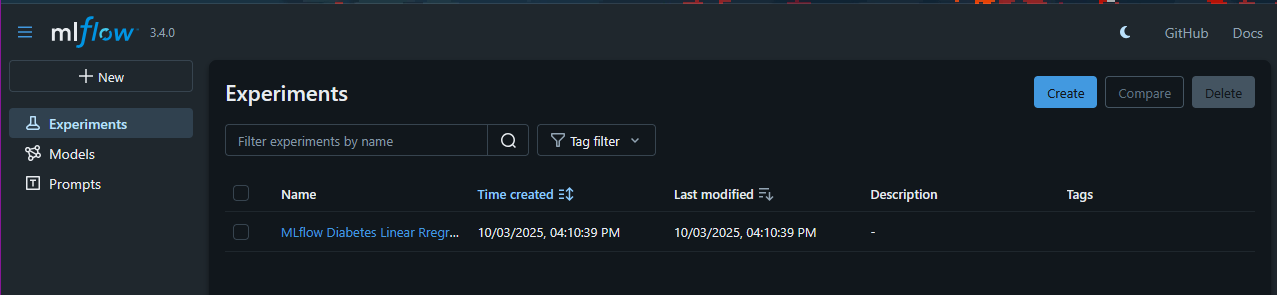

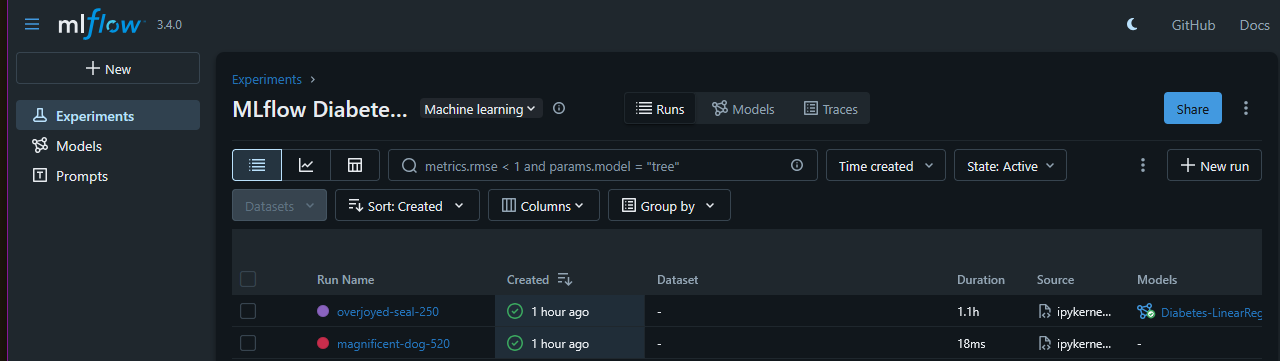

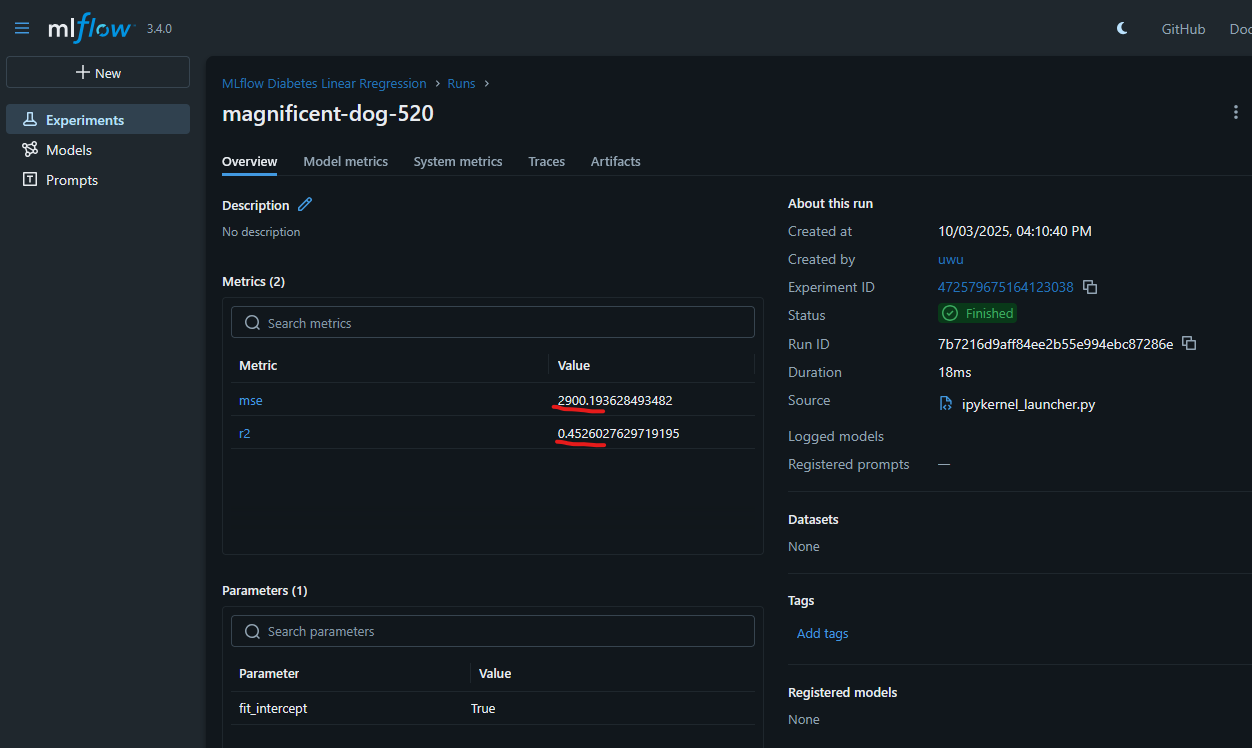

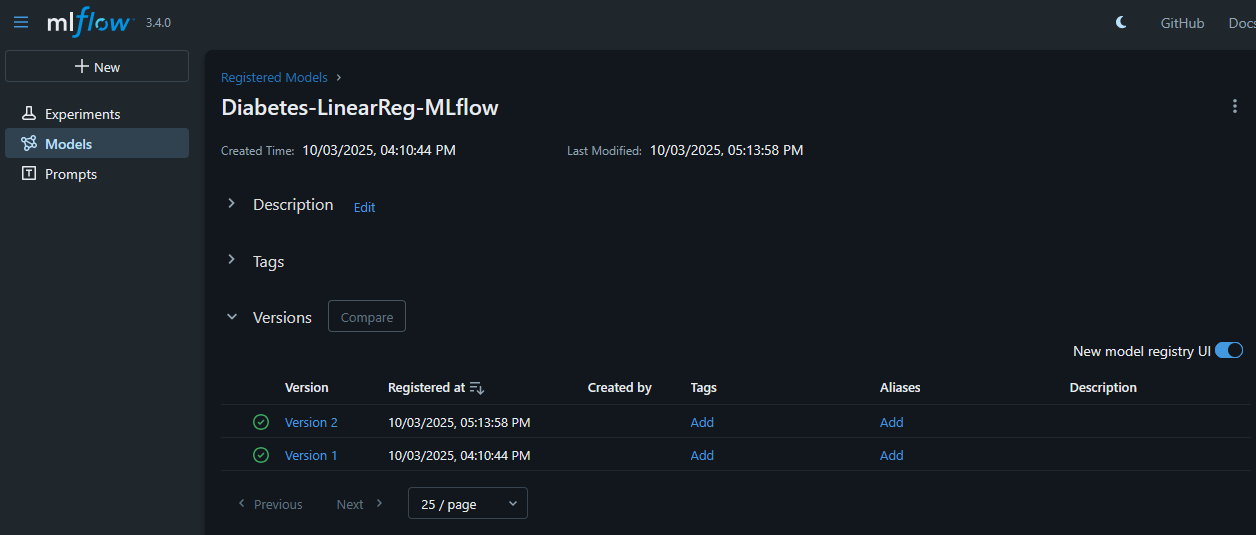